<a href="https://colab.research.google.com/github/dablro12/Monai/blob/main/day1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1일차
Bootcamp의 첫째 날은 MONAI의 핵심에 집중합니다. 변환, 데이터 세트, 캐싱 및 레이어로 시작하여 일반적인 종단 간 워크플로 및 GPU 가속 성능으로 마무리합니다.

## 설치환경 구축

1. 코랩 실행을 위해 필요한 패키지 설치하기 -> 앞에 환경 설정대로 하면 됨 

In [2]:
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.8/584.8 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.6/221.6 KB 27.5 MB/s eta 0:00:00


In [3]:
!nvidia-smi #상태확인

Mon Jan 16 07:27:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Monai 시작하기

### 1. Monai 프레임워크에 대한 이야기 
* Monai는 pytorch기반 헬스케어 이미지를 위한 딥러닝 오픈 소스 프레임워크임.  
* Monai는 nifti, dicom같은 데이터 포맷에 적용될 수 있음.


### 2. Monai Architecture
Monai는 유연하고, 가벼운 API에 다양한 기능을 제공한다. pytorch 프로그램에 존재하는 독립적인 모듈의 요소를 이용해 모나이를 더욱 빠르게 실행할 수 있게 한다. 
* 아래는 monai가 실제로 사용하는 분야에 대해 그림으로 확인 할 수 있다.

[링크 텍스트](https://raw.githubusercontent.com/Project-MONAI/MONAIBootcamp2021/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/arch_modules_v0.4.png)



### 3. Monai Transform
5가지 질문을 통해 Monai transform에 대한 이해를 할 수 있으면 좋겠다. 
1. What transforms are available to help create a data pipeline for training?
2. What are array transforms?
3. What is required to write a custom transform?
4. What are dictionary transforms?
5. How do I create a basic MONAI dataset with transforms?

##실습. 필요한 모듈과 라이브러리 함수들을 다 가지고 와 보자. 아래에는 monai의 다양한 모듈들이다.

In [4]:
import tempfile
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Any, Mapping, Hashable

#아래부터 monai의 라이브러리들
import monai
from monai.config import print_config
from monai.utils import first
from monai.config import KeysCollection
from monai.data import Dataset, ArrayDataset, create_test_image_3d, DataLoader
from monai.transforms import (
    Transform,
    MapTransform,
    Randomizable,
    AddChannel,
    AddChanneld,
    Compose,
    LoadImage,
    LoadImaged,
    Lambda,
    Lambdad,
    RandSpatialCrop,
    RandSpatialCropd,
    ToTensor,
    ToTensord,
    Orientation, 
    Rotate
)
print_config()


MONAI version: 0.6.0
Numpy version: 1.21.6
Pytorch version: 1.13.0+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.0+cu116
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Q1. What transforms are available to help create a data pipeline for training?
학습 데이터 파이프라인을 만들기 위한 formation은 무엇이 있나? 

-1) Medical image data I/O, processing and augmentation

의료용 이미지는 I/O, Preprocessing, Augmentation에 대한 특별한 방법이 요구된다. 의료용 이미지는 rich meta 정보에 대한 format이 존재하는데 이 데이타는 고차원 (N차원)의 데이터를 가지고 있다. Monai 중심의 의료용 미지니는 강력하고 유연하게 각 신체 기능에 따라 이미지를 변환하고 파이프라인을 형성시킬 수 있는 장점이 있다.

-2) Transforms support both Dictionary and Array format data

* 딕셔너리와 배열 포맷 데이터에 대한 형태 = pandas의 df와 비슷한 형태
* 범용적으로 사용하는 vision package는 보통 2D Array가 많지만 Monai는 2D/3D를 다 지원하고, 형태에 대한 유연한 특징을 가지고 있음.
* 의료용 이미지 전처리(preprocessing)는 추가적인 parameter가 필요할 수 있지만, Monai는 파이썬 딕셔너리에 있는 encapsulated Input Data를 parameter로 공급한다.
* 사용자는 이미지에 대한 많은 셋(Crop & Pad, Intensity, IO, Post-processing, Spatial, and Utilities)을 이용해 활용할 수 있다는 장점을 가지고 있다. 

-3) Medical specific transforms

모나이는 다양한 이미지 포맷을 지원한다. 아래 형태의 포맷을 지원하는지 확인할 수 있다.
- LoadImage: Load medical specific formats file from provided path
- Spacing: Resample input image into the specified pixdim
- Orientation: Change the image’s orientation into the specified axcodes
- RandGaussianNoise: Perturb image intensities by adding statistical noises
- NormalizeIntensity: Intensity Normalization based on mean and standard deviation
- Affine: Transform image based on the affine parameters
- Rand2DElastic: Random elastic deformation and affine in 2D
- Rand3DElastic: Random elastic deformation and affine in 3D


 

먼저 우리는 임시 디렉토리를 하나 만들고, 이 디렉토리 내에 몇가지의 예제 Nifti 파일 포맷의 형태를 가지고 올 것이다.
또한 segmentation 페어를 만들자. 

아래에는 nibabel file 만들고 저장하는 방법 
[링크 텍스트](https://kimtaeuk0103.tistory.com/36https://)

In [13]:
fn_keys = ("image", "seg") #filename keys 이미지와 seg files 

root_dir = tempfile.mkdtemp() #디렉토리를 하나 만듬
filenames = [] 
for i in range(5): #안에 5개 만들 예정
  im, seg =create_test_image_3d(256,256,256, num_objs =25, rad_max = 50)
  #im와 seg를 3차원으로 만들기 
  
  #총 5개의 im, seg 파일을 만들것
  im_filename = f"{root_dir}/im{i}.nii.gz"
  seg_filename = f"{root_dir}/seg{i}.nii.gz"
  filenames.append({"img" : im_filename, "seg" : seg_filename})
  #파일이름을 각각 만들어주고
  #nib.Nifti1Image(불러온 파일, 아핀변환) :
  n = nib.Nifti1Image(im, np.eye(4)) #4x4 정방행렬로 대각(\)에 1의 값을 가짐 
  nib.save(n, im_filename) #n이라는 파일을 im_filename과 같게 저장 
  
  n = nib.Nifti1Image(seg, np.eye(4))
  nib.save(n, seg_filename)

### Q2. What are array transforms?

Monai 이미지들은 초기데이터로 부터 불러온 input으로부터 처리된 이미지다. 
다른 구조나 시스템 셋업없이 이미지를 만들 수 있다는 것이 장점.

특히 **compose** 메소드를 통해 operations seq을 만들 수 있다. 

In [18]:
trans = Compose([LoadImage(image_only = True), AddChannel(), ToTensor()])
img = trans(filenames[0]["img"]) #trans 함수 
print(type(img)) # # img : pytorch에 Tensor 타입,  
print(img.shape) #  img는 256*256*256 3차원 배열
print(img.get_device()) # -1
 

<class 'torch.Tensor'>
torch.Size([1, 256, 256, 256])
-1


### Q3. How do I create a custom transform?
이미지 형태를 커스터마이징 하는 법 : Lamda() method 이용 

Lambda 함수를 이용해 람다 형식으로 만들 수 있다.  #자세한 람다 함수 사용법은 아래의 링크로 확인.
[링크 텍스트](https://wikidocs.net/64)

ex) 두 수를 더하는 함수 lambda로 한 줄로 코드 끝내기
(lambda x,y : x+y)(10,20) -> 30 

**우리는 1차원 이미지를 2D 이미지로 바꾸기 위해 Lambda 함수를 이용해 형태를 변환시킬것** 

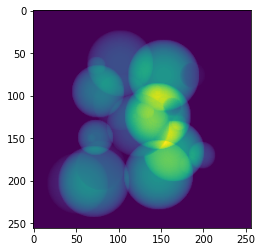

In [34]:
def sum_width(img):
  return img.sum(1) #이미지를 1로 다 처리 

#trans함수 정의
trans = Compose([LoadImage(image_only = True), AddChannel(), Lambda(sum_width)]) 
img = trans(filenames[0]["img"]) #배열을 img형식으로 변환 
plt.imshow(img[0]) #img를 plot해서 보여줌 256* 256사이즈에서 보여줌

transform의 하위 클래스(= 서브 클래스)를 만드는 것은 두번쨰 일이다. 이것은 instantiated object를 정의할 수 있도록 해준다. 아래를 통해 선택한 차원을 더해서 서브 클래스를 만들어 보자.
2차원으로 합해 사용해 보자.

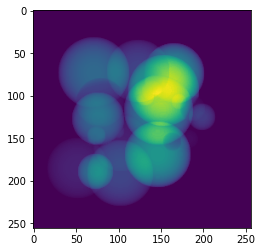

In [35]:
class SumDimension(Transform): #서브 클래스 만드는 함수
  def __init__(self, dim=1): #2차원을 1차원으로 바꿔줌 
    self.dim = dim 
  
  def __call__(self, inputs):
    return inputs.sum(self.dim)

trans = Compose([LoadImage(image_only=True), AddChannel(), SumDimension(2)])
img = trans(filenames[0]["img"]) 
plt.imshow(img[0])

----내일 여기서부터 공부---- 
Run this cell a few times to see the random transform being applied 50% of the time.

In [5]:
class RandAdditiveNoise(Randomizable, Transform):
    def __init__(self, prob: float = 0.5, max_add: float = 1.0) -> None:
        self.prob = np.clip(prob, 0.0, 1.0)
        self.max_add = max_add
        self._noise = 0

    def randomize(self, data: np.ndarray) -> None:
        self._noise = 0

        if self.R.random() < self.prob:
            noise_array = self.R.rand(*data.shape[1:])[None]
            self._noise = (noise_array * self.max_add).astype(data.dtype)

    def add_noise(self, img: np.ndarray) -> np.ndarray:
        return img + self._noise

    def __call__(self, img: np.ndarray) -> np.ndarray:
        self.randomize(img)
        return self.add_noise(img)

trans = Compose([LoadImage(image_only=True), AddChannel(), RandAdditiveNoise()])
img = trans(filenames[0]["img"])
plt.imshow(img[0, 128])

NameError: ignored